In [1]:
# load data
import glob
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer # https://realpython.com/k-means-clustering-python/

# modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report

# load/save model
import pickle

# Load Data

- input: -
- output: `X, y`

In [2]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = glob.glob(path)
    images = np.array([import_image(file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [3]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

X = np.empty((0, 224, 224, 3), np.uint8)
y = np.empty((0))

for character in hanacaraka:
    training_path = "../phiard/Dataset/train/" + character + "/*.png"
    testing_path = "../phiard/Dataset/val/" + character + "/*.png"
    
    temp_X_train, temp_y_train = import_data(character, training_path)
    temp_X_test, temp_y_test = import_data(character, testing_path)
    
    print("Ukuran karakter", character, ":", temp_X_train.shape[0] + temp_X_test.shape[0])
    
    X = np.append(X, temp_X_train, axis=0)
    y = np.append(y, temp_y_train, axis=0)
    X = np.append(X, temp_X_test, axis=0)
    y = np.append(y, temp_y_test, axis=0)


Ukuran karakter ba : 138
Ukuran karakter ca : 132
Ukuran karakter da : 132
Ukuran karakter dha : 132
Ukuran karakter ga : 132
Ukuran karakter ha : 126
Ukuran karakter ja : 132
Ukuran karakter ka : 132
Ukuran karakter la : 132
Ukuran karakter ma : 132
Ukuran karakter na : 132
Ukuran karakter nga : 126
Ukuran karakter nya : 132
Ukuran karakter pa : 132
Ukuran karakter ra : 132
Ukuran karakter sa : 132
Ukuran karakter ta : 132
Ukuran karakter tha : 132
Ukuran karakter wa : 132
Ukuran karakter ya : 132


In [4]:
# Ukuran keseluruhan data
print("Ukuran data:", X.shape[0])

Ukuran data: 2634


<AxesSubplot:ylabel='count'>

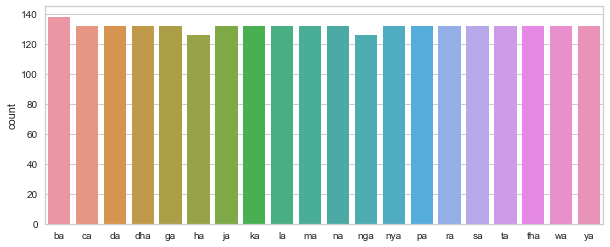

In [5]:
plt.figure(figsize=(10,4))
sns.countplot(x=y)

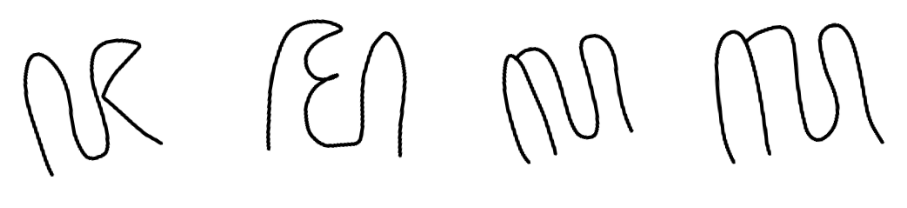

In [79]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, 2154), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Preprocessing

- input: `X`
- output: `X_prep`

kind of image preprocessing
- grayscaling (o)
- resizing (x)
- cropping (x)
- binarization (o)
- negative (x)
- skeletonization/thinning (o)
- noise reduction (x)
- sharpening (o)

In [27]:
def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image
    
def thresholding(image, th):
    ret, image = cv2.threshold(image, th, 255, cv2.THRESH_BINARY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

# https://soumyapatilblogs.medium.com/image-filtering-using-opencv-66b67e1bd968
def denoising(image):
    #image = cv2.fastNlMeansDenoisingColored(img, None, 5, 5, 7, 21)
    image = cv2.medianBlur(image, 5)
    return image

def sharpening(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    #kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    return image

def edge_detecting(image):
    image = grayscaling(image)
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.Canny(image=image, threshold1=100, threshold2=200)
    return image

def preprocessing(image, size=192, th=127):
    image = resizing(image, size)
    image = grayscaling(image)
    image = thresholding(image, th)
    return image

In [49]:
X_prep = []

for i in range(X.shape[0]) :
    X_prep.append(preprocessing(X[i], 28, 224))
    
X_prep = np.array(X_prep, dtype=np.uint8)

In [50]:
print("Dimensi data:", X_prep.shape)

Dimensi data: (2634, 28, 28)


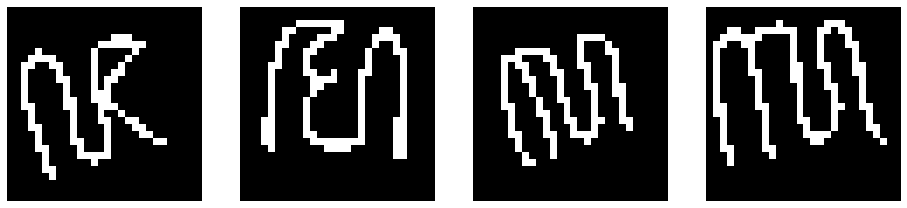

In [51]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X_prep[np.random.randint(0, 2154), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Classification

- input: `X_feature, y`
- output: -

In [52]:
# reshape data
X_feature = np.reshape(X_prep, (2634, 28*28))
X_feature.shape

(2634, 784)

In [53]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

In [54]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)

print("Ukuran data training:", X_train.shape[0])
print("Ukuran data testing:", X_test.shape[0])

Ukuran data training: 2107
Ukuran data testing: 527


## KNN

In [55]:
knn_params = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
knn_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params, cv=5, verbose=3)

In [56]:
knn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.874 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.900 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.891 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.888 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.895 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.777 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=0.770 total time=   0.0s
[CV 3/5] END .....................n_neighbors=3;, score=0.729 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.741 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.789 total time=   0.0s
[CV 1/5] END .....................n_neighbors=5;, score=0.720 total time=   0.0s
[CV 2/5] END .....................n_neighbors=5;

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             verbose=3)

In [57]:
print("Model terbaik:", knn_cv.best_estimator_)
print("Score terbaik:", knn_cv.best_score_)

Model terbaik: KNeighborsClassifier(n_neighbors=1)
Score terbaik: 0.8898931679256116


In [58]:
cv_results_df = pd.DataFrame(knn_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1,{'n_neighbors': 1},1,0.889893,0.008788
3,{'n_neighbors': 3},2,0.761260,0.022430
5,{'n_neighbors': 5},3,0.686747,0.022668
7,{'n_neighbors': 7},4,0.621737,0.016212
9,{'n_neighbors': 9},5,0.581406,0.021551
11,{'n_neighbors': 11},6,0.541051,0.012250
13,{'n_neighbors': 13},7,0.509733,0.010393
15,{'n_neighbors': 15},8,0.490277,0.017251
17,{'n_neighbors': 17},9,0.456577,0.007200


In [59]:
y_pred = knn_cv.predict(X_test)

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.78      1.00      0.88        21
          ca       1.00      0.94      0.97        34
          da       0.90      0.95      0.92        19
         dha       0.97      0.93      0.95        40
          ga       1.00      0.88      0.94        25
          ha       0.92      0.96      0.94        23
          ja       0.96      0.90      0.93        29
          ka       0.92      0.96      0.94        25
          la       1.00      0.88      0.94        26
          ma       0.96      0.96      0.96        28
          na       0.93      1.00      0.96        25
         nga       0.93      0.90      0.91        29
         nya       0.96      0.81      0.88        27
          pa       0.86      0.95      0.90        19
          ra       0.94      1.00      0.97        29
          sa       0.82      0.82      0.82        22
          ta       0.93      0.93      0.93        28
         tha       0.88    

### SVM

In [72]:
svm_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto', 0.0005, 0.0008, 0.0015, 0.0018]
}
svm_cv = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=svm_params, cv=5, verbose=3)

In [73]:
svm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...................C=1, gamma=auto;, score=0.751 total time=   1.1s
[CV 2/5] END ...................C=1, gamma=auto;, score=0.822 total time=   1.2s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.784 total time=   1.2s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.803 total time=   1.1s
[CV 5/5] END ...................C=1, gamma=auto;, score=0.784 total time=   1.1s
[CV 1/5] END .................C=1, gamma=0.0005;, score=0.635 total time=   1.1s
[CV 2/5] END .................C=1, gamma=0.0005;, score=0.709 total time=   1.1s
[CV 3/5] END .................C=1, gamma=0.0005;, score=0.663 total time=   1.1s
[CV 4/5] END .................C=1, gamma=0.0005;, score=0.679 total time=   1.1s
[CV 5/5] END .................C=1, gamma=0.0005;, score=0.663 total time=   1.1s
[CV 1/5] END .................C=1, gamma=0.0008;, score=0.687 total time=   1.1s
[CV 2/5] END .................C=1, gamma=0.0008

[CV 2/5] END ..................C=15, gamma=auto;, score=0.903 total time=   1.3s
[CV 3/5] END ..................C=15, gamma=auto;, score=0.898 total time=   1.3s
[CV 4/5] END ..................C=15, gamma=auto;, score=0.898 total time=   1.3s
[CV 5/5] END ..................C=15, gamma=auto;, score=0.879 total time=   1.3s
[CV 1/5] END ................C=15, gamma=0.0005;, score=0.882 total time=   1.2s
[CV 2/5] END ................C=15, gamma=0.0005;, score=0.898 total time=   1.2s
[CV 3/5] END ................C=15, gamma=0.0005;, score=0.900 total time=   1.2s
[CV 4/5] END ................C=15, gamma=0.0005;, score=0.898 total time=   1.3s
[CV 5/5] END ................C=15, gamma=0.0005;, score=0.888 total time=   1.2s
[CV 1/5] END ................C=15, gamma=0.0008;, score=0.882 total time=   1.2s
[CV 2/5] END ................C=15, gamma=0.0008;, score=0.903 total time=   1.2s
[CV 3/5] END ................C=15, gamma=0.0008;, score=0.898 total time=   1.2s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': ['auto', 0.0005, 0.0008, 0.0015, 0.0018]},
             verbose=3)

In [74]:
print("Model terbaik:", svm_cv.best_estimator_)
print("Score terbaik:", svm_cv.best_score_)

Model terbaik: SVC(C=15, gamma=0.0008)
Score terbaik: 0.8946392588173048


In [75]:
cv_results_df = pd.DataFrame(svm_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
15_0.0008,"{'C': 15, 'gamma': 0.0008}",1,0.894639,0.008401
10_0.0008,"{'C': 10, 'gamma': 0.0008}",2,0.894165,0.009161
15_0.0005,"{'C': 15, 'gamma': 0.0005}",3,0.893216,0.007145
6_0.0008,"{'C': 6, 'gamma': 0.0008}",4,0.892742,0.010390
10_0.0005,"{'C': 10, 'gamma': 0.0005}",5,0.891793,0.008376
10_auto,"{'C': 10, 'gamma': 'auto'}",6,0.889419,0.012840
6_auto,"{'C': 6, 'gamma': 'auto'}",6,0.889419,0.012840
15_auto,"{'C': 15, 'gamma': 'auto'}",6,0.889419,0.012840
3_auto,"{'C': 3, 'gamma': 'auto'}",9,0.888946,0.014225


In [76]:
y_pred = svm_cv.predict(X_test)

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       1.00      0.90      0.95        21
          ca       0.94      0.94      0.94        34
          da       0.94      0.89      0.92        19
         dha       1.00      0.97      0.99        40
          ga       0.95      0.80      0.87        25
          ha       0.85      0.96      0.90        23
          ja       1.00      0.86      0.93        29
          ka       0.67      0.96      0.79        25
          la       1.00      0.88      0.94        26
          ma       1.00      1.00      1.00        28
          na       0.96      0.96      0.96        25
         nga       1.00      0.93      0.96        29
         nya       0.77      1.00      0.87        27
          pa       1.00      0.89      0.94        19
          ra       0.97      1.00      0.98        29
          sa       0.91      0.91      0.91        22
          ta       0.96      0.79      0.86        28
         tha       0.86    